# Generative Adversarial Networks

In this notebook, I will implement a basic GAN using neural networks. This notebook is based on my blog post - which you can check [here](http://jithendrabsyblog.blogspot.com/2020/07/gan.html). We will build models which generate realistic images that resemble training images.

## What is a GAN?

In 2014, Goodfellow and his colleagues presented a method for training generative models called Generative Adversarial Networks. In a GAN, there are two different neural networks.
* The first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (generated). 
* The other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

![GAN architecture](https://skymind.ai/images/wiki/gan_schema.png)

We can think of this back and forth process of the generator trying to fool the discriminator, and the discriminator trying to correctly classify real vs. fake as a two-player minimax game. To optimize this minimax game, we will aternate between taking gradient descent steps on the objective for generator, and gradient ascent steps on the objective for discriminator:

* update the generator to minimize the probability of the discriminator making the correct choice.
* update the discriminator to maximize the probability of the discriminator making the correct choice.

But the above mentioned updates are useful for theoretical analysis, but not perfect in practice. We will make a samll change for updating generator: update generator to maximize the probability of discrriminator making the incorrect choice. This is the standard update used in most GAN varints, and was used in the original paper from Goodfellow. The updated training method will be:

* update the generator to maximize the probability of the discriminator making the incorrect choice.
* update the discriminator to maximize the probability of the discriminator making the correct choice.

In [1]:
# import required dependencies
import torch
import torch.optim as opt
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

## Downloading data

In [2]:
batch_size = 64

transform = transforms.ToTensor()
# load data
trainData = torchvision.datasets.MNIST('./data/', download=True, transform=transform, train=True)
# creating a loader with data - which helps to iterate over the data
trainLoader = torch.utils.data.DataLoader(trainData, shuffle=True, batch_size=batch_size)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/opt/conda/conda-bld/pytorch_1591914880026/work/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [3]:
dataIter = iter(trainLoader)
images, labels = dataIter.next()
images.shape

torch.Size([64, 1, 28, 28])

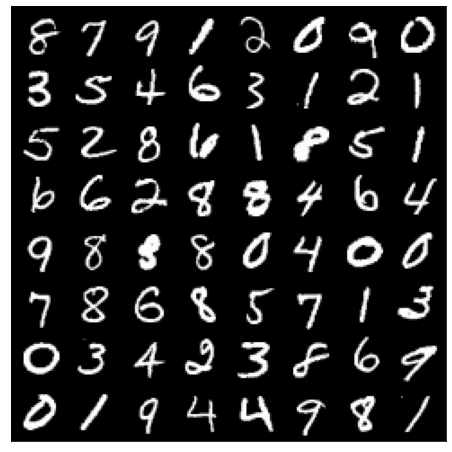

In [4]:
def imshow(images):
    images = torchvision.utils.make_grid(images)
    npimages = images.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimages, (1,2,0)), cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])
    plt.show()

imshow(images)

In [5]:
n_features = 100
X_dim = images.view(images.size(0), -1).size(1)

print(n_features, X_dim)

100 784


## Generator

Now we'll build the generator network

* It returns 784 valued vector, which corresponds to a flattened 28x28 image.
* The last layer will have TanH activation to clip the image to be [-1,1] - which is same size the preprocessed mnist images are bounded.

![generator](https://developers.google.com/machine-learning/gan/images/gan_diagram_generator.svg)

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n_features, 128),
            nn.LeakyReLU(inplace=True),
            nn.Linear(128, 256),
            nn.LeakyReLU(inplace=True),
            nn.Linear(256, X_dim),
            nn.Tanh()
        )
          
    def forward(self, input):
        return self.model(input)

## Discriminator

![discriminator](https://developers.google.com/machine-learning/gan/images/gan_diagram_discriminator.svg)

We'll start building neural networks with the Discriminator. The input size for each image will be 28x28=784. The architecture is:

* Fully connected layer from 784 to 256
* LeakyReLU with alpha 0.01
* Fully connected layer from 256 to 128
* LeakyReLU with alpha 0.01
* Fully connected layer from 128 to 1
*  A Sigmoid function is applied to the real-valued output to obtain a value in the open-range (0, 1)

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(X_dim, 256),
            nn.LeakyReLU(inplace=True),
            nn.Linear(256,128),
            nn.LeakyReLU(inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        
    def forward(self, input):
        return self.model(input)

In [8]:
D = Discriminator()
G = Generator()

print(G)
print(D)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Tanh()
  )
)
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=128, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


## Optimization

We'll use Adam as the optimization algorithm with the learning rate 2e-4 which is not necessarily the optimal value. 

In [9]:
g_opt = opt.Adam(G.parameters(), lr=2e-4)
d_opt = opt.Adam(D.parameters(), lr=2e-4)

## Training

The loss function we will be using for this task is named Binary Cross Entopy Loss (BCE Loss), and it will be used for this scenario as it resembles the log-loss for both the Generator and Discriminator. See this [post](http://jithendrabsyblog.blogspot.com/2020/07/gan.html) for detailed explaination. 

Now, we will find the generator loss and the discriminator loss. And train both the networks alternatively by backpropagating the losses we calculated. 

Discriminator loss function:

![d_loss](https://miro.medium.com/max/700/1*4xAHMaUGXeOQnNJhzjq-4Q.jpeg)


Generator loss function:

![g_loss](https://miro.medium.com/max/700/1*n235XEigXKL3ktL08d-CZA.jpeg)

We will be using Binary Cross Entropy Loss or log loss because it resembles both the generator and the discriminator losses.

![bce](https://miro.medium.com/max/700/1*PK0iVgkQepmVCprtTgbsGg.png)

For training discriminator, if we replace ŷi with D(x) and yi = 1 we will get the real image loss and if we replace ŷi with D(G(z)) and yi = 0 we will get fake image loss. And both these losses should be maximized. But the problem with most of the frameworks is - they minimize the functions. Since, BCE-loss definition has a minus-sign, this won't cause us any problem. 

For training generator, we need to minimize log(1-D(G(z))) which is same as maximizing log(D(G(z))). If we replace ŷi with D(G(z)) and yi = 1, we will get the loss to be maximized. And as we discussed in the above paragraph, PyTorch tries to minimize this function instead of maximizing, but the minus-sign in the BCE-loss definition will help us.

We will also create the real-images targets as ones, and the fake-images targets as zeros with shape (batch_size, 1). These will be help us in calculating the losses of generator and discriminator. 

Epoch:0,   G_loss:1.8183910595709836,    D_loss:0.7554460084959388


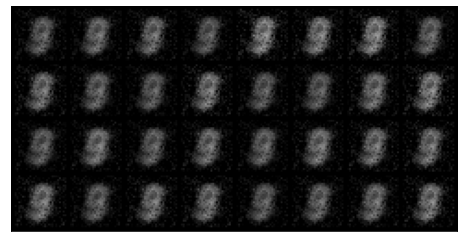

Epoch:1,   G_loss:2.7467426586506973,    D_loss:0.3693048118917482


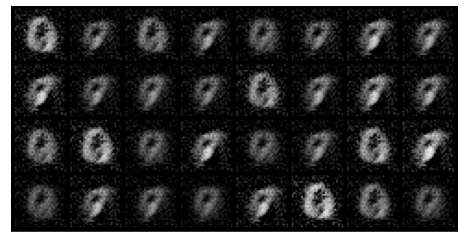

Epoch:2,   G_loss:3.739709887931596,    D_loss:0.25571075442836866


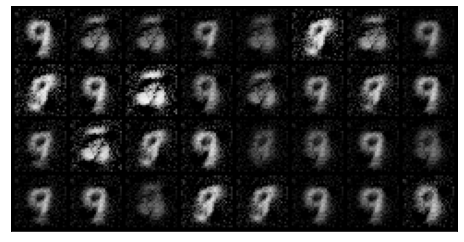

Epoch:3,   G_loss:4.130126015463872,    D_loss:0.21695477647313685


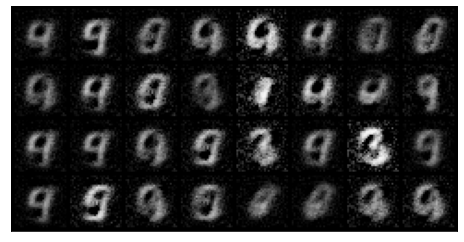

Epoch:4,   G_loss:4.244034718094604,    D_loss:0.20408510126824828


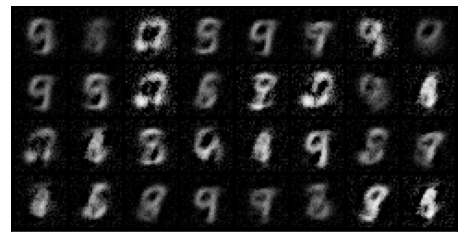

Epoch:5,   G_loss:4.622229796991165,    D_loss:0.17867770546804995


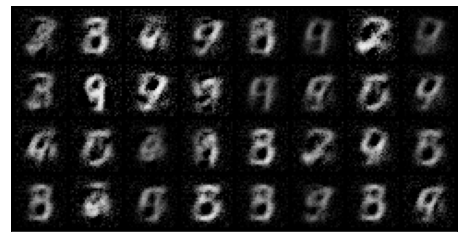

Epoch:6,   G_loss:4.911991189791958,    D_loss:0.16995493713210322


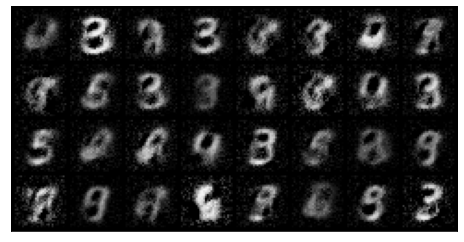

Epoch:7,   G_loss:5.151693279046748,    D_loss:0.14938382133603223


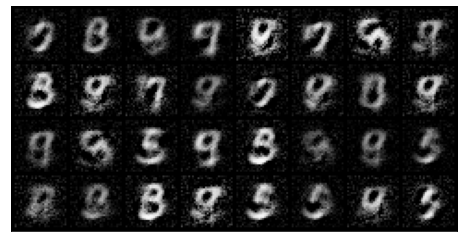

Epoch:8,   G_loss:5.180929286901884,    D_loss:0.15681241565882398


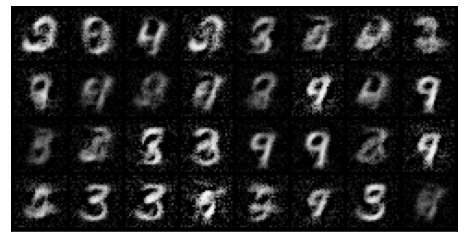

Epoch:9,   G_loss:5.3763572633393535,    D_loss:0.17144592354165467


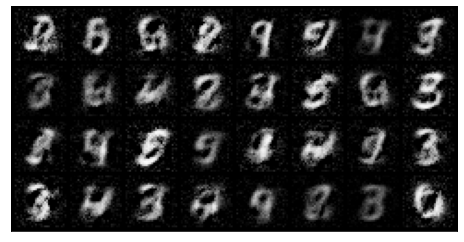

Epoch:10,   G_loss:5.227890995011401,    D_loss:0.17107675155438085


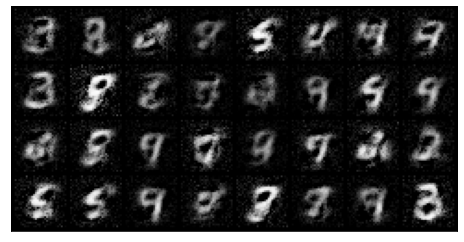

Epoch:11,   G_loss:5.0839723587544485,    D_loss:0.20442497057081666


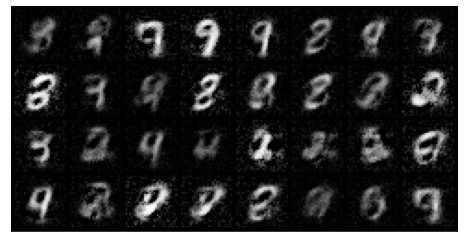

Epoch:12,   G_loss:4.9804657163904675,    D_loss:0.21024407374896983


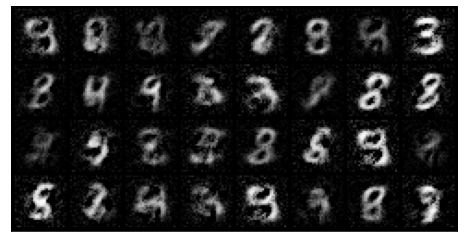

Epoch:13,   G_loss:5.064601000438112,    D_loss:0.20811870816086275


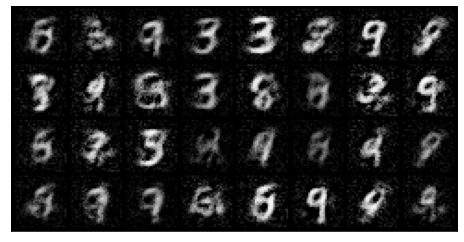

Epoch:14,   G_loss:4.949291255682517,    D_loss:0.19641511779087883


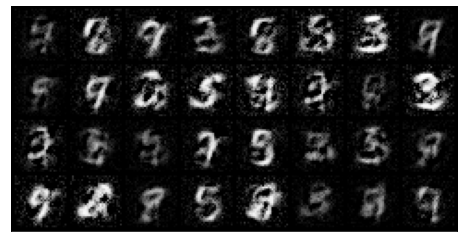

Epoch:15,   G_loss:5.021681925635348,    D_loss:0.2026357158764339


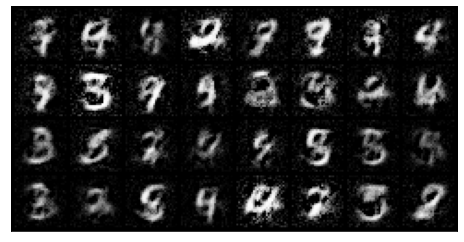

Epoch:16,   G_loss:4.832493851433939,    D_loss:0.21441190787898834


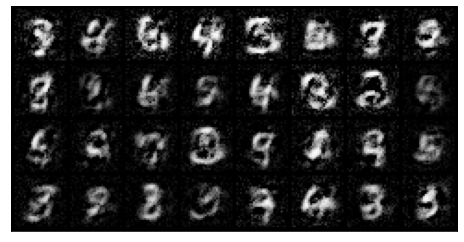

Epoch:17,   G_loss:4.7196900417555625,    D_loss:0.21945884367868082


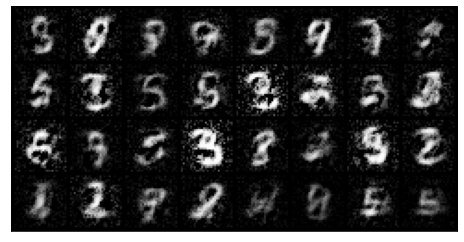

Epoch:18,   G_loss:4.8045403299046985,    D_loss:0.22399063654609327


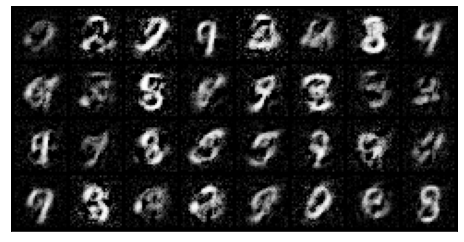

Epoch:19,   G_loss:4.706412436103007,    D_loss:0.22412460680995414


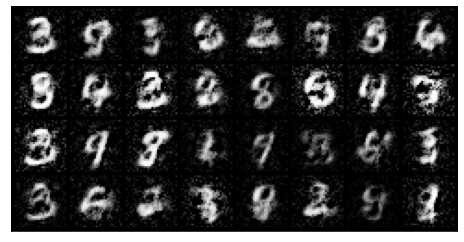

In [10]:
for epoch in range(20):
    G_loss_update = 0.0
    D_loss_update = 0.0
    for i, data in enumerate(trainLoader):
        X, _ = data
        X = X.view(X.size(0), -1)
        batch_size = X.size(0)
        
        # tensor containing ones representing real data target
        real_target = torch.ones(batch_size, 1)
        # tensor containing zeroes representing generated data target
        generated_target = torch.zeros(batch_size, 1)
        
        z = torch.randn(batch_size, n_features)
        
        # 1. Train discriminator
        # on real data
        D_real = D(X)
        # calculating real data error
        D_real_loss = F.binary_cross_entropy(D_real, real_target)
        
        # on generated data
        D_generated = D(G(z))
        # calculating generated data error
        D_generated_loss = F.binary_cross_entropy(D_generated, generated_target)
        
        # Total discriminator loss
        D_loss = D_real_loss + D_generated_loss
        
        # reset gradients
        d_opt.zero_grad()
        # backpropagate
        D_loss.backward()
        # update weights with gradients
        d_opt.step()
        
        # 2. Train generator
        # sample noise and generate some fake data
        z = torch.randn(batch_size, n_features)
        D_generated = D(G(z))
        # calculating error
        G_loss = F.binary_cross_entropy(D_generated, real_target)
        
        # resetting gradients, backpropagating and updating weights
        g_opt.zero_grad()
        G_loss.backward()
        g_opt.step()
        
        G_loss_update = G_loss_update + G_loss.item()
        D_loss_update = D_loss_update + D_loss.item()
        
    print('Epoch:{},   G_loss:{},    D_loss:{}'.format(epoch, G_loss_update/(i+1), D_loss_update/(i+1)))
    
    samples = G(z).detach()
    samples = samples.view(samples.size(0), 1, 28, 28).cpu()
    imshow(samples)

Hooray, We have successfully implemented a GAN!!!

You can get more realistic results if you increase the number of epochs.

Stay tuned for more notebooks! 